In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
from transient_V_A_fall_utils import psiam_tied_data_gen_trans_V_A
import pandas as pd

# params

In [2]:
V_A = 1.1
theta_A = 1.8

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.03
t_E_aff = 0.05
t_motor = 0.03

Z_E = 0
L = 0.5

N_sim = int(50e3)
dt = 1e-4

V_A_step_size = 2
new_V_A_time_const = 0.05
N_print = int(10e3)


# ABL, ILD, stim and led times from data

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


# simulate many

In [4]:
V_A_change_results_dict = {}
for i in range(5):
    new_V_A = V_A + V_A_step_size*i

    with parallel_backend('threading', n_jobs=-1):
        sim_results = Parallel()(
            delayed(psiam_tied_data_gen_trans_V_A)(V_A, theta_A, ABL_arr, ILD_arr,\
                                                    rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, t_stim_and_led_tuple,\
                                                    new_V_A, new_V_A_time_const , iter_num, N_print, dt)
            for iter_num in range(N_sim)
        )

    print(f'V_A: {V_A}, new_V_A: {new_V_A}')

    V_A_change_results_dict[i] = {'results': sim_results, 'new_V_A': new_V_A, 'V_A': V_A, }

os id: 1859965, In iter_num: 0, ABL: 40, ILD: -4.0, t_stim: 1.03609637410854
os id: 1859965, In iter_num: 10000, ABL: 60, ILD: 16.0, t_stim: 0.240183056564688
os id: 1859965, In iter_num: 20000, ABL: 40, ILD: -4.0, t_stim: 0.327512885026464
os id: 1859965, In iter_num: 30000, ABL: 20, ILD: 16.0, t_stim: 0.597021907632255
os id: 1859965, In iter_num: 40000, ABL: 40, ILD: -8.0, t_stim: 0.261393613113262
V_A: 1.1, new_V_A: 1.1
os id: 1859965, In iter_num: 0, ABL: 20, ILD: 2.0, t_stim: 0.25421744321082
os id: 1859965, In iter_num: 10000, ABL: 40, ILD: -16.0, t_stim: 0.269885755703737
os id: 1859965, In iter_num: 20000, ABL: 40, ILD: -2.0, t_stim: 0.407435200488857
os id: 1859965, In iter_num: 30000, ABL: 20, ILD: -2.0, t_stim: 0.350370688195859
os id: 1859965, In iter_num: 40000, ABL: 40, ILD: 8.0, t_stim: 0.306647017538313
V_A: 1.1, new_V_A: 3.1
os id: 1859965, In iter_num: 0, ABL: 20, ILD: -4.0, t_stim: 0.355881235923084
os id: 1859965, In iter_num: 10000, ABL: 40, ILD: 2.0, t_stim: 0.52

# aborts distr and number?

In [5]:
base_data = V_A_change_results_dict[0]['results']
change_idx = 4
new_V_A = V_A_change_results_dict[change_idx]['new_V_A']
change_data = V_A_change_results_dict[change_idx]['results']

In [6]:
base_aborts_on = []
base_aborts_off = []

change_aborts_on = []
change_aborts_off = []

for res in base_data:
    if res['is_LED_trial'] == 1 and res['rt'] < res['t_stim'] and res['rt'] > res['t_led']:
        base_aborts_on.append(res['rt'] - res['t_stim'])
    if (not res['is_LED_trial']) and res['rt'] < res['t_stim'] and res['rt'] > res['t_led']:
        base_aborts_off.append(res['rt'] - res['t_stim'])

for res in change_data:
    if res['is_LED_trial'] == 1 and res['rt'] < res['t_stim'] and res['rt'] > res['t_led']:
        change_aborts_on.append(res['rt'] - res['t_stim'])
    if (not res['is_LED_trial']) and res['rt'] < res['t_stim'] and res['rt'] > res['t_led']:
        change_aborts_off.append(res['rt'] - res['t_stim'])
        

Text(0, 0.5, 'density')

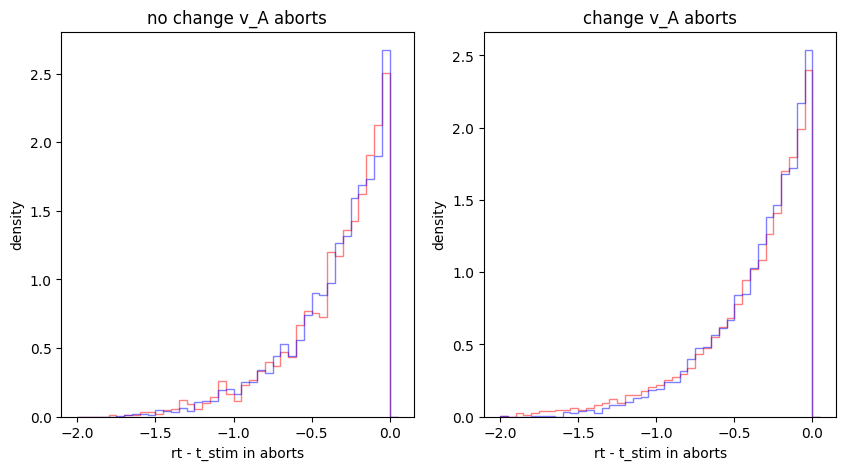

In [7]:
plt.figure(figsize=(10, 5))
bins = np.arange(-2, 0.1, 0.05)
plt.subplot(1, 2, 1)
plt.hist(base_aborts_on, bins=bins, alpha=0.5, label='base LED on', density=True, color='r', histtype='step')
plt.hist(base_aborts_off, bins=bins, alpha=0.5, label='base LED off', density=True, color='b', histtype='step')
plt.title('no change v_A aborts')
plt.xlabel('rt - t_stim in aborts')
plt.ylabel('density')

plt.subplot(1,2,2)
plt.hist(change_aborts_on, bins=bins, alpha=0.5, label='change LED on', density=True, color='r', histtype='step')
plt.hist(change_aborts_off, bins=bins, alpha=0.5, label='change LED off', density=True, color='b', histtype='step')
plt.title('change v_A aborts')
plt.xlabel('rt - t_stim in aborts')
plt.ylabel('density')


In [8]:
# number of aborts
change_num_of_aborts = len(change_aborts_on) + len(change_aborts_off)
base_num_of_aborts = len(base_aborts_on) + len(base_aborts_off)
print(f'change_num_of_aborts: {change_num_of_aborts}, base_num_of_aborts: {base_num_of_aborts}')

change_num_of_aborts: 13856, base_num_of_aborts: 5487


# psychometric

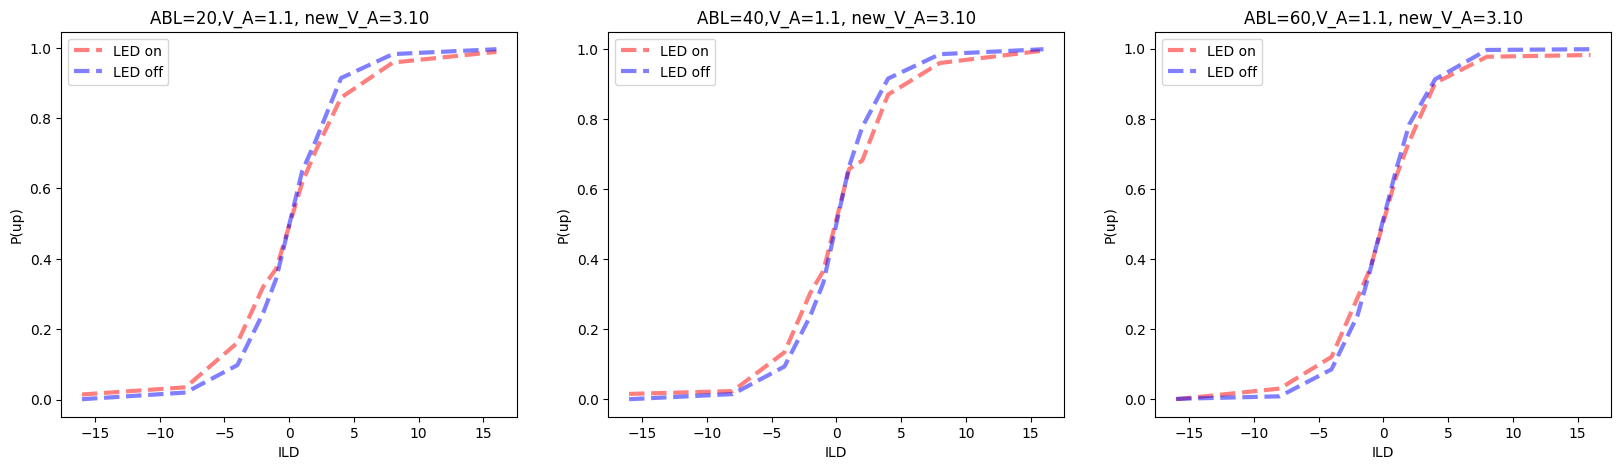

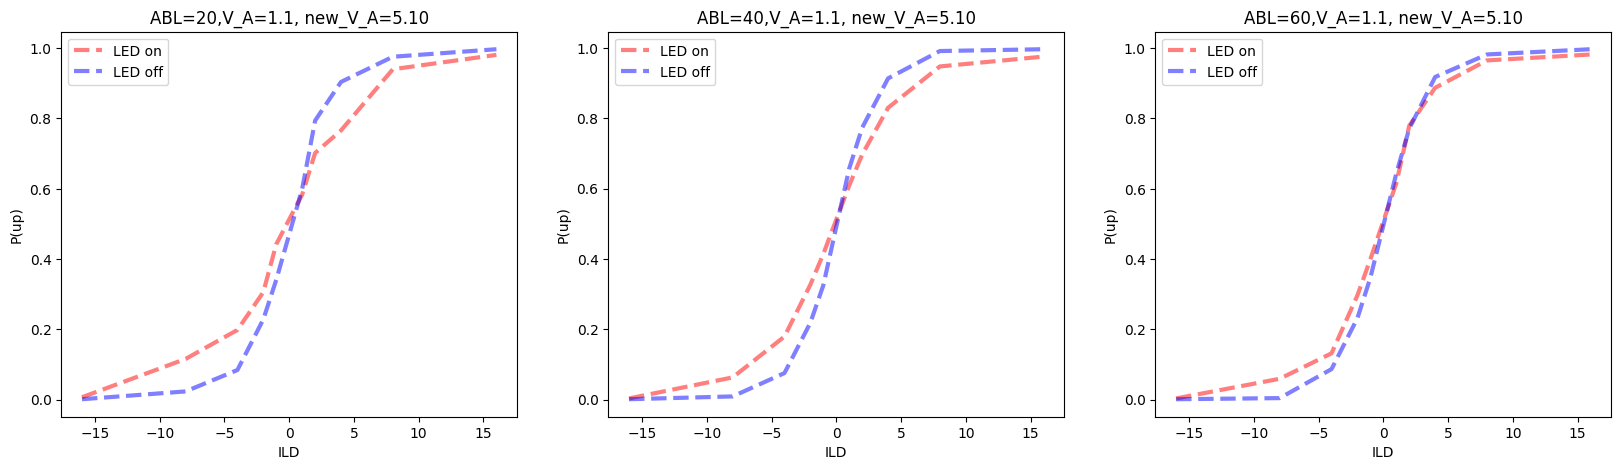

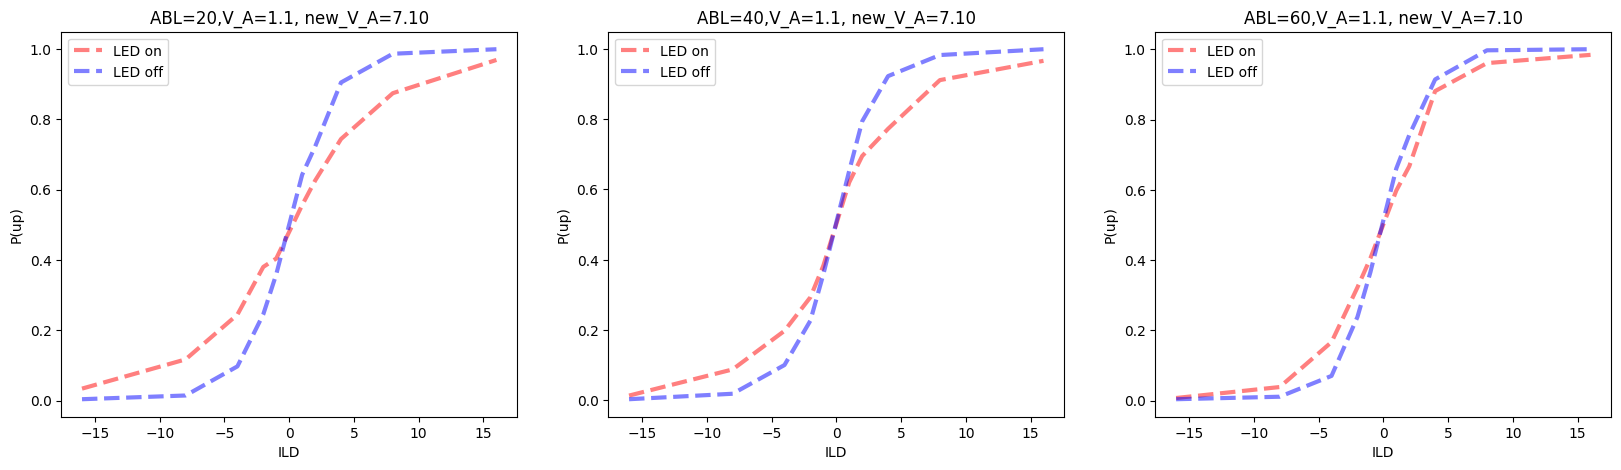

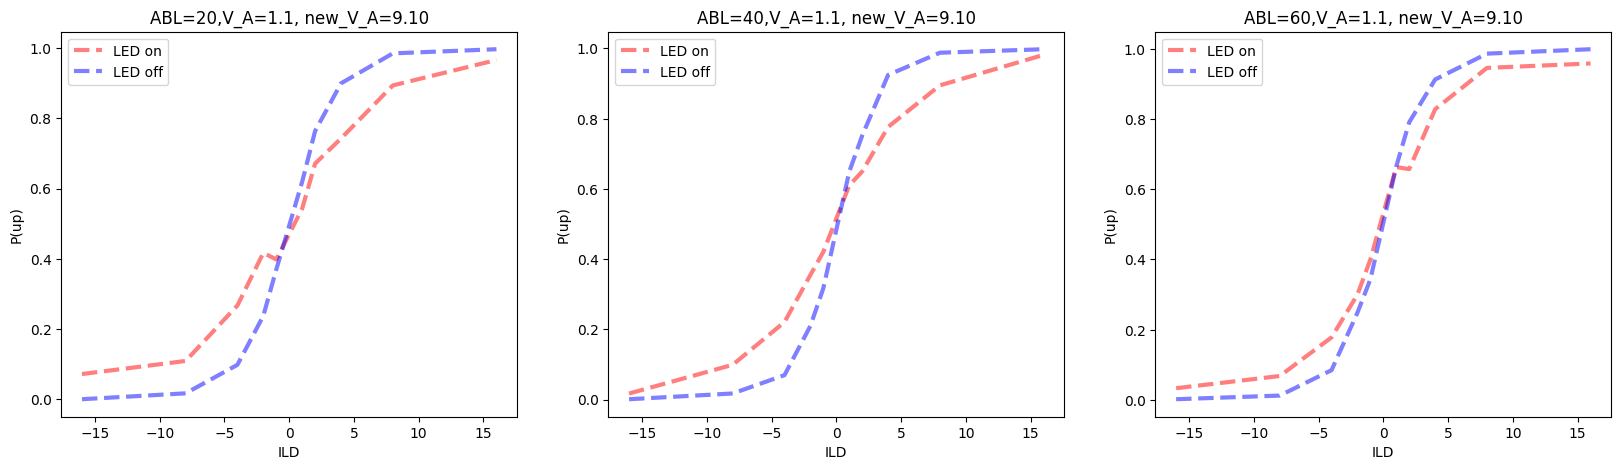

In [9]:
for i in range(1, 5):
    # for each V_A
    each_V_A_results = V_A_change_results_dict[i]['results']
    base_V_A =  V_A_change_results_dict[i]['V_A']
    new_V_A = V_A_change_results_dict[i]['new_V_A']

    num_up_on = {}; num_trials_on = {}
    num_up_off = {}; num_trials_off = {}
    for ABL in ABL_arr:
        num_up_on[ABL] = np.zeros_like(ILD_arr)
        num_trials_on[ABL] = np.zeros_like(ILD_arr)

        num_up_off[ABL] = np.zeros_like(ILD_arr)
        num_trials_off[ABL] = np.zeros_like(ILD_arr)

    
    for res in each_V_A_results:
        ABL = res['ABL']
        ILD = res['ILD']
        is_LED_trial = res['is_LED_trial']
        if is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_on[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        elif not is_LED_trial:
            if res['rt'] > res['t_stim'] and res['rt'] > res['t_led']:
                num_trials_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
                if res['choice'] == 1:
                    num_up_off[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

        

        

    plt.figure(figsize=(20,5))
    for a, ABL in enumerate(ABL_arr):
        plt.subplot(1, len(ABL_arr), a+1)
        plt.title(f'ABL={ABL},V_A={base_V_A}, new_V_A={new_V_A:.2f}')

        
        plt.plot(ILD_arr, num_up_on[ABL]/num_trials_on[ABL], label='LED on', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, num_up_off[ABL]/num_trials_off[ABL], label='LED off', linestyle='--', color='b', lw=3, alpha=0.5)
        
        plt.legend()
        plt.xlabel('ILD'); plt.ylabel('P(up)');




# percentiles

In [10]:
base_V_A_data = V_A_change_results_dict[0]['results']


# change V_A
new_V_A_idx = 1
new_V_A_value = V_A_change_results_dict[new_V_A_idx]['new_V_A']
new_V_A_data = V_A_change_results_dict[new_V_A_idx]['results']


In [11]:
base_on_abl_ild = {}
base_off_abl_ild = {}

new_on_abl_ild = {}
new_off_abl_ild = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        base_on_abl_ild[(ABL, int(ILD))] = []
        base_off_abl_ild[(ABL, int(ILD))] = []

        new_on_abl_ild[(ABL, int(ILD))] = []
        new_off_abl_ild[(ABL, int(ILD))] = []

for res in base_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            base_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            base_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])


for res in new_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    is_LED_trial = res['is_LED_trial']
    if is_LED_trial:
        if res['rt'] > res['t_led']:
            new_on_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])
    elif not is_LED_trial:
        if res['rt'] > res['t_led']:
            new_off_abl_ild[ABL, int(ILD)].append(res['rt'] - res['t_stim'])

In [12]:
base_on_percentiles_dict = {}
base_off_percentiles_dict = {}

new_on_percentiles_dict = {}
new_off_percentiles_dict = {}

percentiles = [10, 30, 50, 70, 90]


for ABL in ABL_arr:
    base_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    base_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))

    new_on_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))
    new_off_percentiles_dict[ABL] = np.zeros((len(percentiles), len(ILD_arr)))


for ABL in ABL_arr:
    for ild_idx,ILD in enumerate(ILD_arr):
        for p, percentile in enumerate(percentiles):
            base_on_percentiles_dict[ABL][(p, ild_idx)] = np.percentile(base_on_abl_ild[ABL, int(ILD)], percentile)
            base_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(base_off_abl_ild[ABL, int(ILD)], percentile)

            new_on_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_on_abl_ild[ABL, int(ILD)], percentile)
            new_off_percentiles_dict[ABL][p, ild_idx] = np.percentile(new_off_abl_ild[ABL, int(ILD)], percentile)

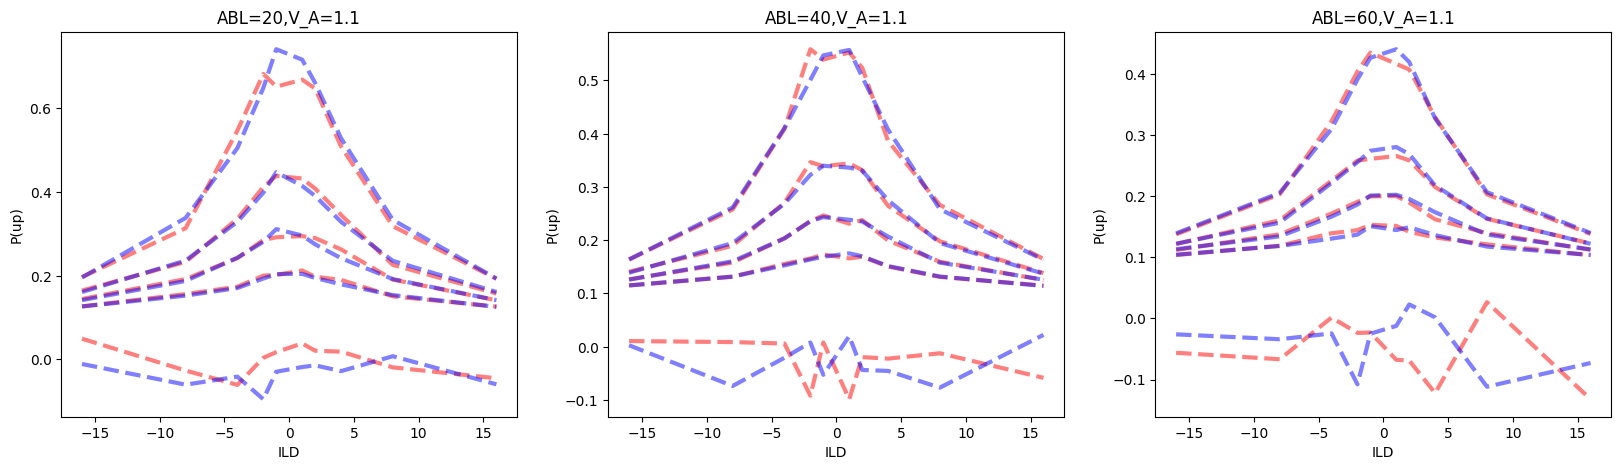

In [13]:
# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},V_A={base_V_A}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, base_on_percentiles_dict[ABL][p], label=f'base ON {percentile}', linestyle='--', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, base_off_percentiles_dict[ABL][p], label=f'base OFF {percentile}', linestyle='--', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('P(up)');

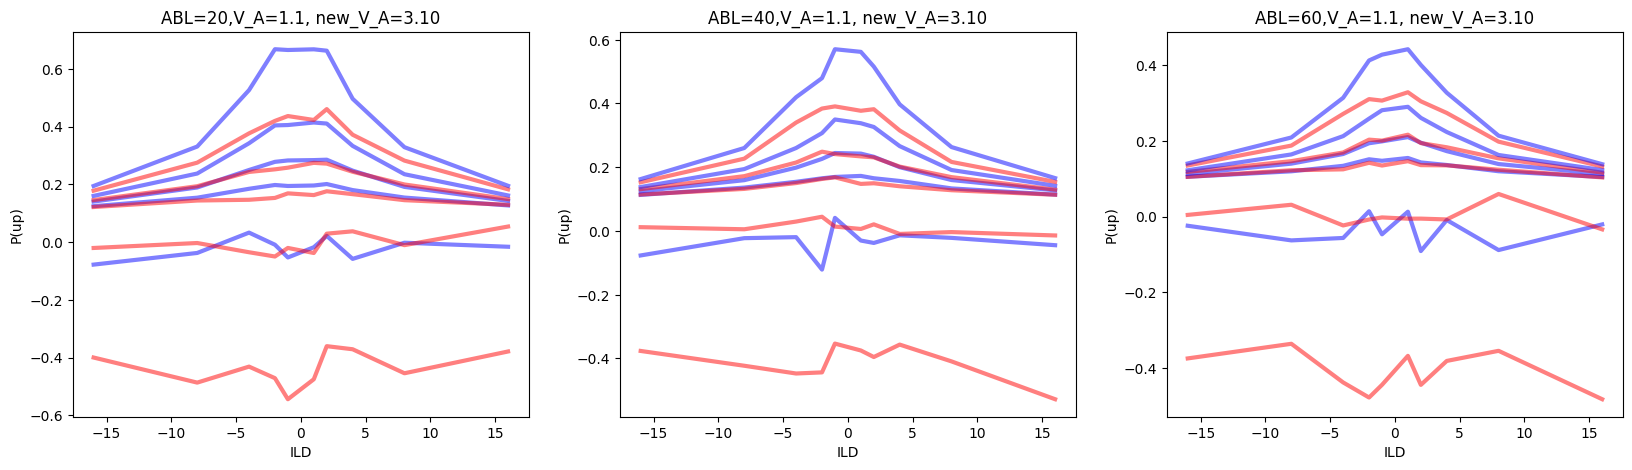

In [14]:
# plot
plt.figure(figsize=(20,5))
for a, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), a+1)
    plt.title(f'ABL={ABL},V_A={base_V_A}, new_V_A={new_V_A_value:.2f}')
    for p, percentile in enumerate(percentiles):
        plt.plot(ILD_arr, new_on_percentiles_dict[ABL][p], label=f'new ON {percentile}', linestyle='-', color='r', lw=3, alpha=0.5)
        plt.plot(ILD_arr, new_off_percentiles_dict[ABL][p], label=f'new OFF {percentile}', linestyle='-', color='b', lw=3, alpha=0.5)



    plt.xlabel('ILD'); plt.ylabel('P(up)');

# chronometric

In [20]:
positive_ILD_arr = ILD_arr[ILD_arr > 0]

In [21]:
# base and new init- collect rt
base_rt_abl_ild_on = {}
base_rt_abl_ild_off = {}

new_rt_abl_ild_on = {}
new_rt_abl_ild_off = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_rt_abl_ild_on[(ABL, ILD)] = []
        base_rt_abl_ild_off[(ABL, ILD)] = []

        new_rt_abl_ild_on[(ABL, ILD)] = []
        new_rt_abl_ild_off[(ABL, ILD)] = []

In [22]:
#  base
for res in base_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            base_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            base_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

# new
for res in new_V_A_data:
    ABL = res['ABL']
    ILD = res['ILD']
    abs_ILD = np.abs(ILD)

    if res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            new_rt_abl_ild_on[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])
    elif not res['is_LED_trial']:
        if res['rt'] > res['t_led']:
            new_rt_abl_ild_off[(ABL, abs_ILD)].append(res['rt'] - res['t_stim'])

In [23]:
# base
base_on_mean = {}
base_on_std_err = {}

base_off_mean = {}
base_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        base_on_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_on[(ABL, ILD)])
        base_on_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_on[(ABL, ILD)]))

        base_off_mean[(ABL, ILD)] = np.mean(base_rt_abl_ild_off[(ABL, ILD)])
        base_off_std_err[(ABL, ILD)] = np.std(base_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(base_rt_abl_ild_off[(ABL, ILD)]))


# new
new_on_mean = {}
new_on_std_err = {}

new_off_mean = {}
new_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        new_on_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_on[(ABL, ILD)])
        new_on_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_on[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_on[(ABL, ILD)]))

        new_off_mean[(ABL, ILD)] = np.mean(new_rt_abl_ild_off[(ABL, ILD)])
        new_off_std_err[(ABL, ILD)] = np.std(new_rt_abl_ild_off[(ABL, ILD)]) / np.sqrt(len(new_rt_abl_ild_off[(ABL, ILD)]))

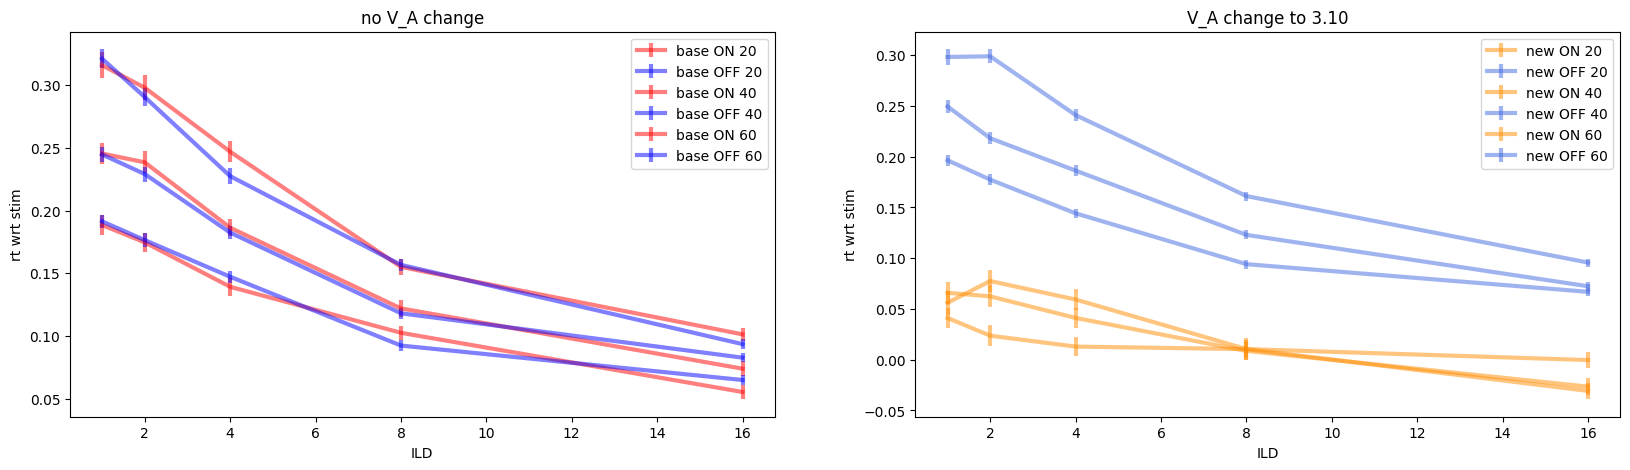

In [24]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
# base - mean with std err vs pos ILD
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [base_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[base_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'base ON {ABL}', color='r', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [base_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[base_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'base OFF {ABL}', color='b', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title('no V_A change')

plt.subplot(1,2,2)
# new - mean with std err vs pos ILD
for ABL in ABL_arr:
    plt.errorbar(positive_ILD_arr, [new_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new ON {ABL}', color='darkorange', lw=3, alpha=0.5)
    plt.errorbar(positive_ILD_arr, [new_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[new_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label=f'new OFF {ABL}', color='royalblue', lw=3, alpha=0.5)
    plt.legend()
    plt.xlabel('ILD'); plt.ylabel('rt wrt stim')
    plt.title(f'V_A change to {new_V_A_value:.2f}')